# Exploring TC PRIMED, Chapter 1c: The Environmental File
- Creators: Naufal Razin, Chris Slocum, and Kathy Haynes
- Affiliations: CIRA and NESDIS/STAR

---

## Overview
TC PRIMED consists of two types of files: the overpass file and the environmental file. The overpass file contains all available satellite products from *one* overpass of a tropical cyclone, while the environmental file contains all available tropical cyclone information, and environmental diagnostics and fields *at synoptic times* (00, 06, 12, 18 UTC) throughout the storm's life. In this notebook, you will learn how to read data from the TC PRIMED environmental file.

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:
- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- NetCDF files and NetCDF groups (see Chapter 1a of this Learning Journey)
- plotting data using `matplotlib`

In addition, we will be using other Python packages to plot geospatial and meteorological data. You don't need to be fully versed in these packages, but being somewhat familiar with them would be helpful. These packages are:
- [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html)
- [`metpy`](https://unidata.github.io/MetPy/latest/userguide/index.html)

## Learning Outcomes
By working through this notebook, you should be able to:
- understand the data structure of a TC PRIMED environmental file
- interact with (e.g., load and plot) data from a TC PRIMED environmental file

## Background
Data in the TC PRIMED environmenal files are stored in five different NetCDF groups. They are:
- `storm_metadata`, which contains information about the storm
- `overpass_metadata`, which contains information about all available overpasses for the storm
- `overpass_storm_metadata`, which contains information about the storm during all available overpasses
- `diagnostics`, which contains environmental diagnostics calculated from the ECMWF fifth-generation reanalysis fields (ERA5)
- `rectilinear`, which contains environmental fields from ERA5

In this notebook, you will learn to load and plot data from the `storm_metadata`, `diagnostics`, and `rectilinear` groups. These groups have variables that represent different information about the storm at each synoptic time (00, 06, 12, 18 UTC) throughout the storm's life.

For example, the `storm_metadata` group contains information about the storm, like its location and intensity, as analyzed by forecasters at the National Hurricane Center, The Central Pacific Hurricane Center, and the Joint Typhoon Warning Center. The `diagnostics` group contains information about the storm's environment, like the amount of atmospheric moisture available around the storm. Forecasters actively rely on these environmental variables to forecast the intensity of the storm. Finally, the `rectilinear` group contains fields of environmental data from the ECMWF fifth-generation reanalysis (ERA5).

To get familiarized with these products, let's look at the TC PRIMED environmental file from Hurricane Florence (2018).

<figure>
<img alt="An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station." src="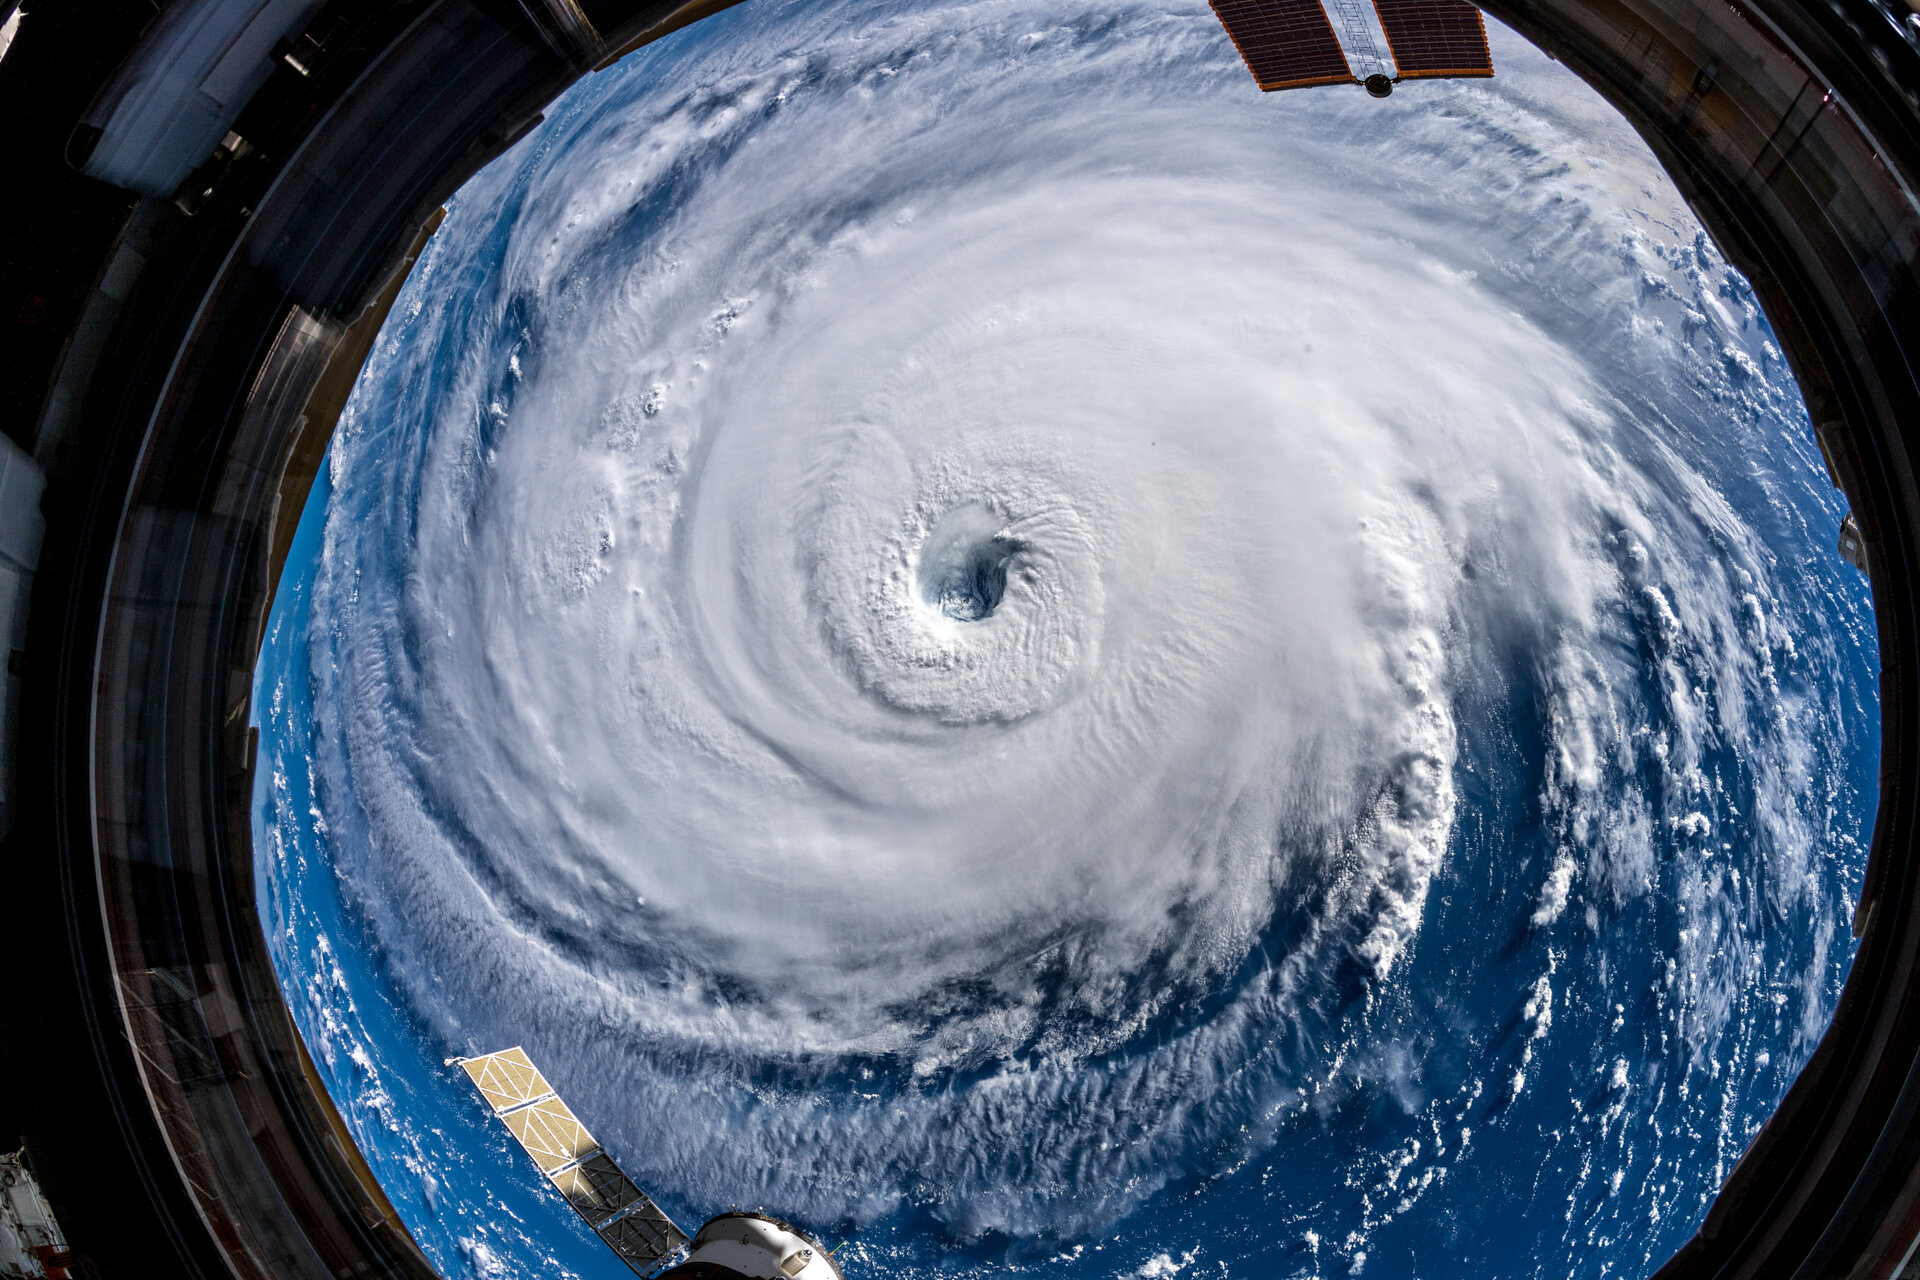" width="900">

<figcaption align = "center"><b>Figure 1.</b> An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station. Source: <a href="https://www.esa.int/ESA_Multimedia/Images/2018/09/Above_Hurricane_Florence">ESA</a></figcaption>
<figure>

Hurricane Florence was a long-lived hurricane that formed off the coast of Senegal and The Gambia, and tracked westward across the North Atlantic Ocean. During its track across the Atlantic, it briefly intensified to a Category 4 hurricane (on the [Saffir-Simpson Hurricane Wind Scale](https://www.nhc.noaa.gov/aboutsshws.php#:~:text=The%20Saffir%2DSimpson%20Hurricane%20Wind,Scale%20estimates%20potential%20property%20damage.)), weakened to a tropical storm, and re-intensified back to a Category 4 hurricane before making landfall along the southeastern coast of North Carolina as a high-end Category 1 hurricane. Florence brought [record-breaking rainfall](https://www.weather.gov/ilm/HurricaneFlorence) across eastern North Carolina and parts of northeastern South Carolina.

Using data from the environmental file, you will plot the intensity trends of Hurricane Florence, as well as the the environmental variables within which it was embedded.

## Software
This tutorial uses the Python programming language and packages. We will use:
- `netCDF4` to read in the TC PRIMED file
- `matplotlib` to plot the data
- `cartopy` to plot the data on a map
- `metpy` to plot a skew-T diagram
- `numpy` for simple array operations

### Install Packages
Let's first check if we have the necessary Python packages to run this notebook. If we don't, let's install them.

In [ ]:
import subprocess, sys
packages = ["netCDF4", "matplotlib", "metpy",
            "cartopy", "numpy"]
# If this notebook is running on Google Colab, we know what packages
# need to be installed. In addition, we would have to resolve some
# incompatibility issues between shapely and cartopy.
if 'google.colab' in sys.modules:
    !pip install netCDF4
    !pip install metpy
    !apt-get -V -y -qq install python-cartopy python3-cartopy
    !pip uninstall shapely -y
    !pip install shapely --no-binary shapely
    !pip install cartopy

# If this note book is not running on Google Colab, check if Python
# has the packages we need to run this notebook. If not, download it
else:
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now, let's load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `as plt`) for a cleaner use throughout the notebook.

In [ ]:
# Load the Python packages we will use in this notebook
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
import numpy as np

### Read File Online
Finally, let's retrieve information from the TC PRIMED file that we will use in this example. As we have mentioned above, we will learn to read and plot data from a TC PRIMED environmental file from Hurricane Florence (2018). We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the TC PRIMED file available on an Amazon Web Service S3 bucket as part of the NOAA Open Data Dissemination program (NODD), without downloading the file, and store the information from the file in an "instance" type called `DS`.

In [ ]:
import requests

# Specify the URL to the TC PRIMED folder on NODD
NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r00/final/2018/AL/06/"

# Specify the name of the file we will use from the TC PRIMED folder on NODD
FILE_NAME = "TCPRIMED_v01r00-final_AL062018_era5_s20180830060000_e20180918120000.nc"

# Join NODD_URL and FILE_NAME to produce a complete link
# Retrieve the contents of the TC PRIMED file from the complete link
url_response = requests.get(NODD_URL + FILE_NAME)

# Load the contents of the TC PRIMED file in an "instance" called DS
DS = Dataset(FILE_NAME, memory=url_response.content)

## Part 1: Loading and plotting the storm metadata
If you've gone through the previous two chapters, you should be somewhat familiar with the concept of NetCDF groups, instances, and variables in Python. But, for the sake of completeness, let's print out the instance from the root group of the environmental file.

In [ ]:
# DS would automatically contain information from the root group
# Print the instance of the file from the root group
print(DS)

Notice, as we have discussed above, the root group contains five sub-groups. Let's print out the instance of the ```storm_metadata``` group.

In [ ]:
# Using the file instance, load the storm_metadata group as a
# group instance called storm_metadata_group
storm_metadata_group = DS["storm_metadata"]

# Print the storm_metadata group instance
print(storm_metadata_group)

Now let's read the time and intensity variables from the `storm_metadata` group.


In [ ]:
# Using the file instance, load the time and intensity variables from the
# storm_metadata group by specifying its "path" in the file, and using [:]
# to load the variable
storm_metadata_time = DS["storm_metadata/time"][:]
storm_metadata_intensity = DS["storm_metadata/intensity"][:]

### Brief remark
The time variable in all TC PRIMED overpass and environmental files exists in units of seconds since 1970-01-01T00:00:00. This unit of time is also referred to as the [Unix time stamp](https://en.wikipedia.org/wiki/Unix_time). To make the time values cleaner for plotting, you can convert it to a string using the Python datetime module. Let's briefly go through this process.

In [ ]:
# For each unix time element in storm_metadata_time, convert the unix time
# to a Python datetime object and assign it to the variable storm_metadata_datetime
storm_metadata_datetime = [datetime.datetime.fromtimestamp(t) for t in storm_metadata_time]

# Now, for each datetime object element in storm_metadata_datetime, convert the datetime
# to string in the format of month/day hour
storm_metadata_datetime_str = [t.strftime("%m/%d %H") for t in storm_metadata_datetime]

Now you're ready to plot the data!

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Make the plot
plt.plot(storm_metadata_datetime_str, storm_metadata_intensity, color="k", lw=1)

# Plot the time at every fourth time point, with the values rotated by 45 degrees
plt.xticks(storm_metadata_datetime_str[::4], storm_metadata_datetime_str[::4], rotation=45, fontsize=14, ha="right")

plt.ylabel("Intensity (knots)", fontsize=14)
plt.yticks(fontsize=14)

To identify the different Saffir-Simpson *categories* in the plot above, you can add alternating shaded boxes to the plot. You just have to specify the bounds of each category, given below:
- 0 - 33 knots : Tropical Depression (TD)
- 34 - 64 knots : Tropical Storm (TS)
- 65 - 83 knots : Category 1 (Cat. 1)
- 84 - 95 knots : Category 2 (Cat. 2)
- 96 - 113 knots : Category 3 (Cat. 3)
- 114 - 134 knots : Category 4 (Cat. 4)
- Above 134 knots : Category 5 (Cat. 5), but for plotting purposes, let's cap it at 185

Let's re-make the plot above with the Saffir-Simpson categories labeled.

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Make the plot
plt.plot(storm_metadata_datetime_str, storm_metadata_intensity, color="k", lw=1)

# Plot the time at every fourth time point, with the values rotated by 45 degrees
plt.xticks(storm_metadata_datetime_str[::4], storm_metadata_datetime_str[::4], rotation=45, fontsize=14, ha="right")

plt.ylabel("Intensity (knots)", fontsize=14)
plt.yticks(fontsize=14)

# Add shaded boxes for TS, Cat 2, and Cat 4 Saffir-Simpson categories
plt.axhspan(34, 64, color="grey", alpha=0.25)
plt.axhspan(84, 95, color="grey", alpha=0.25)
plt.axhspan(114, 134, color="grey", alpha=0.25)

# Add text labels for the Saffir-Simpson categories
plt.text(storm_metadata_datetime_str[0], 48, "TS", 
         fontsize=25, color="k", ha="left", va="center")
plt.text(storm_metadata_datetime_str[0], 73, "CAT1", 
         fontsize=25, color="k", ha="left", va="center")
plt.text(storm_metadata_datetime_str[0], 88.5, "CAT2", 
         fontsize=25, color="k", ha="left", va="center")
plt.text(storm_metadata_datetime_str[0], 103.5, "CAT3", 
         fontsize=25, color="k", ha="left", va="center")
plt.text(storm_metadata_datetime_str[0], 123, "CAT4", 
         fontsize=25, color="k", ha="left", va="center")

From the figure above, you can clearly identify the periods in which Hurricane Florence intensified to a Category 4 hurricane (around September 5th), weakened to a tropical storm (around September 7th through 9th), and reintensified back to a Category 4 hurricane (around September 10th through 12th).

You can also plot a track of Hurricane Florence on a map. To do that, load the storm latitude and longitude data from the ```storm_metadata``` group.

In [ ]:
# Using the file instance, load the storm latitude and longitude
# variables from the storm_metadata group by specifying its "path"
# in the file, and using [:] to load the variable
storm_metadata_latitude = DS["storm_metadata/storm_latitude"][:]
storm_metadata_longitude = DS["storm_metadata/storm_longitude"][:]

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 7.5))

# Generate a map projection on which to plot the data
ax = plt.axes(projection=ccrs.Mercator())

# Plot the coastlines on the map
ax.coastlines()

# Insert latitude and longitude grid lines
ax.gridlines(draw_labels=True)

# Plot a black line showing the track of the storm onto the map
plt.plot(storm_metadata_longitude, storm_metadata_latitude, color="k", transform=ccrs.Geodetic(), lw=0.75)

# Plot the location of the storm at each synoptic time
plt.scatter(storm_metadata_longitude, storm_metadata_latitude, color="k", transform=ccrs.Geodetic())

### But, wait!

You can plot the storm track and intensity simultaneously on a map. To do this, you can use the contour version of `plt.scatter` and assign the intensity to the contour argument (e.g., `plt.scatter(storm_metadata_lon, storm_metadata_lat, c=storm_metadata_intensity)`).

However, you can also add more parameters to overlay the hurricane intensity category on a map by customizing your own colormap. To do so, we'll use the bounds for each category given above and replicated below
- 0 - 33 knots : Tropical Depression (TD)
- 34 - 64 knots : Tropical Storm (TS)
- 65 - 83 knots : Category 1 (Cat. 1)
- 84 - 95 knots : Category 2 (Cat. 2)
- 96 - 113 knots : Category 3 (Cat. 3)
- 114 - 134 knots : Category 4 (Cat. 4)
- Above 134 knots : Category 5 (Cat. 5), but for plotting purposes, let's cap it at 185

Using these ranges, let's generate our own custom colormap.

In [ ]:
# Specify bounds based on the Saffir-Simpson Hurricane Wind Scale categories
bounds = [0, 33, 64, 83, 95, 113, 134, 185]

# Specify colormap
cmap = plt.cm.plasma

# Generate custom colormap
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

With this custom colormap, you can plot the storm location and intensity *category* simultaneously.

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 7.5))

# Generate a map projection on which to plot the data
ax = plt.axes(projection=ccrs.Mercator())

# Plot the coastlines on the map
ax.coastlines()

# Insert latitude and longitude grid lines
ax.gridlines(draw_labels=True)

# Plot a line showing the track of the storm onto the map
plt.plot(storm_metadata_longitude, storm_metadata_latitude,color="k", transform=ccrs.Geodetic(), lw=0.75)

# Plot a contour of storm category at each time point onto the map
plt.scatter(storm_metadata_longitude, storm_metadata_latitude, c=storm_metadata_intensity, cmap=cmap, norm=norm, transform=ccrs.Geodetic(), zorder=2)

# Generate and label colorbar
cb = plt.colorbar(fraction=0.024)
cb.set_label("Intensity", size=14)

# Set colorbar tick location and categories
cb.set_ticks([17,49.5,74.5,90,105,124.5,160])
cb.set_ticklabels(["TD","TS","Cat. 1","Cat. 2","Cat. 3","Cat. 4","Cat. 5"], size=14)

## Part 2: Loading and plotting the environmental diagnostics
Tropical cyclone environmental diagnostics are a set of information that characterize the environment around a tropical cyclone. This diagnostic information come from numerical weather model output fields, with different parameters calculated at or across different radial regions and vertical levels (for a complete list, see Table 1 from Slocum et al. 2022). Forecasters rely on environmental diagnostics to better predict tropical cyclone intensity change, making them one of the most useful forecast tools for forecasting tropical cyclones.

TC PRIMED contains environmental information calculated from the ECMWF version 5 reanalysis fields (ERA5). In Part 2 and Part 3 of this notebook, you will learn to plot the diagnostic parameters as well as the diagnostic fields from ERA5. Let's first begin by looking at the environmental vertical shear of the horizontal winds, or simply, the vertical shear.

### Part 2A: The environmental vertical shear of the horizontal winds

The vertical shear parameter represents the difference between the wind speed and direction at lower levels compared to the upper levels. A bigger vertical shear magnitude represents a bigger difference in the wind speed and direction between the lower and upper levels. In environments with strong vertical shear, tropical cyclones cannot maintain their structure and will most likely weaken.

Let's first load and print out the diagnostics group instance.

In [ ]:
# Using the file instance, load the diagnostics group as a
# group instance called diagnostics_group
diagnostics_group = DS["diagnostics"]

# Print out the diagnostics group instance
print(diagnostics_group)

<div class="alert alert-block alert-success">
<h3>Exercise 1</h3> Read through the printout of the diagnostics group instance above. In the list of available variables, locate the variable name for the magnitude of the vertical shear. Using that variable name, complete the uncomment the template below and change the code as necessary to load and print the <i>variable instance</i> for the magnitude of the vertical shear.
</div>

<div class="alert alert-block alert-info">
<b>Hint:</b> You only need to use <code>[:]</code> when loading the variable. Not its instance.

In [ ]:
# Using the file instance, load the variable instance for vertical
# shear magnitude in the diagnostics group by specifying its "path"
# in the file
#shear_magnitude_instance = DS["insert_shear_magnitude_variable_here"]

# Print out the shear magnitude variable instance
#print(shear_magnitude_instance)

From the printout above, you should see that the `shear_magnitude` variable has a dimension of `(time, layer, regions)` with a shape of `(78, 2, 2)`. In other words, there are 78 times at which the shear magnitude variable is available (recall, at each synoptic time throughout the storm's life), for two different layers, and for two different regions.

These layers and regions are listed in the printout above. That is, the first entry in the `layer` dimension corresponds to vertical shear magnitude calculated between the 850 and 500 hPa layers, whereas the second entry in the `layer` dimension corresponds to vertical shear magnitude calculated between the 850 and 200 hPa layers.

Similarly, the first entry in the `regions` dimension corresponds to vertical shear magnitude calculated for the region between 0 and 500 km from the storm center, while the second entry in the `regions` dimension corresponds to vertical shear magnitude calculated for the region between 200 and 800 km from the storm center.

Let's plot the evolution of the vertical shear magnitude throughout the storm's life alongside the evolution of the intensity of Hurricane Florence, like we have done above. We will do this for the shear mangitude calculated for:
- the layer between 850 and 200 hPa, the second entry in the `layer` dimension
- the region between 0 and 500 km from the storm center the first entry in the `regions` dimension

In [ ]:
# Using the file instance, load the shear magnitude variable from the
# diagnostics group by specifying its "path" in the file
# Use the appropriate index to load the shear magnitude that we have
# defined above
# time index = : for all entries of the time dimension
# layer index = 1 for the second entry of the layer dimension
# region index = 0 for the first entry of the region dimension
shear_magnitude = DS["diagnostics/shear_magnitude"][:,1,0]

Before we proceed, recall that the TC PRIMED environmental files contain information about the storm and its environment at each synoptic time throughout the storm's life. Therefore, the time variable in the `storm_metadata`, `diagnostics`, and `rectilinear` groups are all the same. To plot the time evolution of the vertical shear magnitude alongside the intensity, we can either load a time variable from the `diagnostics` group, or simply use the time variable from the `storm_metadata` group that we have loaded above.

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the time evolution of the intensity of Hurricane Florence
# in a solid black line as "intensity_line"
intensity_line = plt.plot(storm_metadata_datetime_str, storm_metadata_intensity, color="k", lw=1, label="Intensity")

# Plot the time at every fourth time point, with the values rotated by 45 degrees
plt.xticks(storm_metadata_datetime_str[::4], storm_metadata_datetime_str[::4], rotation=45, fontsize=14, ha="right")

# Add labels for the intensity
plt.ylabel("Intensity (knots)", fontsize=14)
plt.yticks(fontsize=14)

# Create a new axis that shares the same x axis as the intensity
# plot above
plt.twinx()

# Plot the time evolution of the shear magnitude around Hurricane Florence
# in dashed black line as "shear_line"
shear_line = plt.plot(storm_metadata_datetime_str, shear_magnitude, color="k", ls="dashed", lw=1, label="Shear Magnitude")

# Add labels for the shear magnitude
plt.ylabel("Shear Magnitude (m/s)", fontsize=14)
plt.yticks(fontsize=14)

# Add legend for the lines
# We need to account for the fact that we have two axis objects,
# since we used "plt.twinx()"
figure_lines = intensity_line + shear_line
figure_labels = [line.get_label() for line in figure_lines]
plt.legend(figure_lines, figure_labels)

The magnitude of the vertical shear is not the only environmental factor that affects hurricane intensity. But its impact is non-negligible. Notice from the plot above, as the shear magnitude decreases, Florence intensified soon after. And as the shear magnitude increases, Florence weakened soon after.

### Part 2B: The vertical profile of temperature and dewpoint temperature
In addition to scalar values that describe the tropical cyclone environment, like the shear magnitude that we looked at above, environmental information also exists in other forms, like a vertical profile of temperature and dewpoint temperature. You can obtain these vertical profiles from the TC PRIMED environmental file. We will be using the `level`, `temperature`, and `relative_humidity` variables to construct a vertical profile. Let's first look at their variable instances.

In [ ]:
# Using the file instance, load the variable instance for level,
# temperature, and relative humidity in the diagnostics group by
# specifying its "path" in the file
level_instance = DS["diagnostics/level"]
temperature_instance = DS["diagnostics/temperature"]
relative_humidity_instance = DS["diagnostics/relative_humidity"]

# Print out the variable instances
print(level_instance)
print(" ")
print(temperature_instance)
print(" ")
print(relative_humidity_instance)

The `level` variable corresponds to the vertical atmospheric levels in hPa, of which there are 21. For the `temperature` and `relative_humidity` variables, there are 78 data points for time (again, at each synoptic time throughout the storm's life), 21 vertical levels (for each atmospheric level), and averaged over two regions (0 to 500 km and 200 to 800 km).

Let's plot a vertical profile of temperature and dewpoint temperature:
- at the first analysis time
- for the region averaged between 200 and 800 km

We will need to set up the variables for plotting using metpy utilities following the [example](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html) from the metpy tutorial.

In [ ]:
# Using the file instance, load the shear magnitude variable from the
# diagnostics group by specifying its "path" in the file
# Use the appropriate index to load the shear magnitude that we have
# defined above
# time index = 0 for the first analysis time
# level index = : for all vertical atmospheric levels
# region index = 1 for the second entry of the region dimension
# Metpy does not work on the mask array that gets automatically
# assigned when we load a variable from a NetCDF file. So, we must
# convert the variables into a numpy array before applying a metpy
# unit type to each variable
diagnostics_temperature = np.array(DS["diagnostics/temperature"][0, :, 1]) * units.kelvin
diagnostics_relative_humidity = np.array(DS["diagnostics/relative_humidity"][0, :, 1]) * units.percent
diagnostics_level = np.array(DS["diagnostics/level"][:]) * units.hPa

In [ ]:
# Using another metpy utility that we have loaded above,
# obtain the dewpoint temperature from the temperature and
# relative humidity
diagnostics_dewpoint = dewpoint_from_relative_humidity(diagnostics_temperature, diagnostics_relative_humidity)

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(diagnostics_level, diagnostics_temperature, 'darkorange', linewidth=3, label='Temperature')
skew.plot(diagnostics_level, diagnostics_dewpoint, 'royalblue', linewidth=3, label='Dewpoint')
fig.legend()

## Part 3: Loading and plotting the rectilinear ERA5 data
Last, but not least, let's look at the environmental field variables from ERA5, stored in the `rectilinear` group of the TC PRIMED environmental file. The ERA5 environmental fields in TC PRIMED exist in the form of a box, 20-degree longitude wide and 20-degree latitude tall, centered on the model tropical cyclone center. In other words, as the model tropical cyclone moves, the box moves along with it. Therefore, there is a different set of longitude and latitude values for each analysis time. Slocum et al. (2022) discuss the differences between the model and observed tropical cyclone center.

Note, however, that ERA5 has a 0.25 degree latitude and longitude resolution. So, including the longitude and latitude value at the center of the box, our 20-degree longitude by 20-degree latitude box should contain 81 longitudinal and latitudinal points, respectively.

Before we look at the environmental fields, let's re-visit the intensity plot of Hurricane Florence.

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Make the plot
plt.plot(storm_metadata_datetime_str, storm_metadata_intensity, color="k", lw=1)

# Plot the time at every fourth time point, with the values rotated by 45 degrees
plt.xticks(storm_metadata_datetime_str[::4], storm_metadata_datetime_str[::4], rotation=45, fontsize=14, ha="right")

plt.ylabel("Intensity (knots)", fontsize=14)
plt.yticks(fontsize=14)

From the plot above, Florence reached its peak intensity on September 11th at 12 UTC. However, before reaching its peak intensity, it underwent a period of weakening that ended on September 7th at 00 UTC. What does the low-level relative humidity field look like at these two different times? Let's load the variable and plot them!

You can see a list of available variables in the `rectilinear` group by printing the group instance like we have done above. But, we will skip that step for this example.

In [ ]:
# Load all variables
rectilinear_relative_humidity = DS["rectilinear/relative_humidity"][:]
rectilinear_latitude = DS["rectilinear/latitude"][:]
rectilinear_longitude = DS["rectilinear/longitude"][:]
rectilinear_level = DS["rectilinear/level"][:]

# Since we're not using the time directly to plot, we can keep this
# in its unixtime format
rectilinear_time = DS["rectilinear/time"][:]

As we have noted above, we are interested in two analysis times. Let's specify them below, convert them to unix time units, and create a date and time string at each time for plotting purposes.

In [ ]:
analysis_time_1 = datetime.datetime(2018, 9, 7, 0, 0)
analysis_unix_time_1 = datetime.datetime.timestamp(analysis_time_1)
analysis_time_1_str = analysis_time_1.strftime("%Y/%m/%d %H%M UTC")

analysis_time_2 = datetime.datetime(2018, 9, 11, 12, 0)
analysis_unix_time_2 = datetime.datetime.timestamp(analysis_time_2)
analysis_time_2_str = analysis_time_2.strftime("%Y/%m/%d %H%M UTC")

First, let's look at the list of pressure levels that we can analyze by printing out the `rectilinear_level` variable.

In [ ]:
print(rectilinear_level)

Then, let's create the conditions to extract the latitude, longitude, and relative humidity data at the two corresponding times and single pressure level (let's go with 850 hPa for example).

In [ ]:
level_choice = 850
condition_time_1 = rectilinear_time == analysis_unix_time_1
condition_time_2 = rectilinear_time == analysis_unix_time_2
condition_level = rectilinear_level == level_choice

In [ ]:
relative_humidity_time_1 = np.squeeze(rectilinear_relative_humidity[condition_time_1, condition_level, :, :], axis=0)
latitude_time_1 = np.squeeze(rectilinear_latitude[condition_time_1, :], axis=0)
longitude_time_1 = np.squeeze(rectilinear_longitude[condition_time_1, :], axis=0)

relative_humidity_time_2 = np.squeeze(rectilinear_relative_humidity[condition_time_2, condition_level, :, :], axis=0)
latitude_time_2 = np.squeeze(rectilinear_latitude[condition_time_2, :], axis=0)
longitude_time_2 = np.squeeze(rectilinear_longitude[condition_time_2, :], axis=0)

Finally, let's plot the low-level relative humidity fields at the two different analysis times, side-by-side! We will use [this Cartopy example](https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html) to make our two-panel plot, and [this Cartopy example](https://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html) to clean up our plot gridline labels.

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.Mercator()},
                        figsize=(11, 8.5))

axs=axs.flatten()

axs[0].coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False
gl0.xlocator = mticker.FixedLocator(np.arange(-180,181,2.5))
gl0.right_labels=False
gl0.xlocator = mticker.FixedLocator(np.arange(-90,91,2.5))
axs[0].contourf(longitude_time_1, latitude_time_1, relative_humidity_time_1, transform=ccrs.PlateCarree(),
                levels=np.arange(0, 101, 5), cmap="GnBu")
axs[0].set_title(str(level_choice) + " hPa Relative Humidity at\n" + analysis_time_1_str)

axs[1].coastlines()
gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False
gl1.xlocator = mticker.FixedLocator(np.arange(-180,181,2.5))
gl1.right_labels=False
gl1.xlocator = mticker.FixedLocator(np.arange(-90,91,2.5))
cs = axs[1].contourf(longitude_time_2, latitude_time_2, relative_humidity_time_2, transform=ccrs.PlateCarree(),
                     levels=np.arange(0, 101, 5), cmap="GnBu")
axs[1].set_title(str(level_choice) + " hPa Relative Humidity at\n" + analysis_time_2_str)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

The plot above shows that at the first analysis time, right at the end of the first weakning of Hurricane Florence, there is a large area of low atmospheric relative humidity at 850 hPa, to the east of the storm center that wrapped around to the northwest of the storm center. This area of low relative humidity likely contributed to the weakening of Hurricane Florence. Conversely, at the peak of Florence's intensity, there are only smaller and discrete areas of low atmospheric relative humidity, with a concentrated area of high relative humidity near the center of the storm.

## Practice
1. *Estimates* of the minimum central pressure for a tropical cyclone are not always available. But in the case of Hurricane Florence, estimates of the minimum central pressure are available throughout the storm's life. Using the example from Part 2A, plot the evolution of the intensity and minimum central pressure of Hurricane Florence. What kind of relationship do you observe between the intensity and the minimum central pressure?
2. Another factor that affects tropical cyclone intensity is the sea surface temperature over which it is located. Higher sea surface temperatures are more conducive for tropical cyclone intensification. Replicate the relative humidity plot in Part 3 by plotting the sea surface temperature field from the `rectilinear` group at the two different times. Compare the sea surface temperature plot with the relative humidity plot and the evolution of the shear magnitude that you have analyzed in Part 2B. Which of these environmental factors do you think has the biggest impact on the tropical cyclone intensity at the two different times?

## Close the File
When loading data from a NetCDF file, **always remember to close the file**. A best practice would be to close the file immediately after loading the variable or attribute of interest. However, since we're loading various variables and attributes throughout this notebook, we will close the file at the end of this notebook using the command below.

In [ ]:
DS.close()

## Final Thoughts
This tutorial highlights just a subset of the variables available in the TC PRIMED environmental file, including the ways in which you can plot them. To recap, in this tutorial, you learned how to:
- load and plot the storm metadata
- load and plot the storm diagnostics, including a vertical profile of temperature and dewpoint temperature
- load and plot a field variable from ERA5, collocated with the model storm center

## Data Statement
- Razin, Muhammad Naufal; Slocum, Christopher J.; Knaff, John A.; Brown, Paula J. 2023. Tropical Cyclone PRecipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED). v01r00. NOAA National Centers for Environmental Information. https://doi.org/10.25921/dmy1-0595.

## References
- Slocum, C. J., M. N. Razin, J. A. Knaff, and S. P. Stow, 2022: Does ERA5 mark a new era for resolving the tropical cyclone environment? J. Climate., 35, 3547–3564, https://doi.org/10.1175/JCLI-D-22-0127.1.

## Metadata
- Language / package(s)
     - Python
     - NetCDF
     - Matplotlib
     - cartopy
     - metpy
     - numpy
- Domain
    - NOAA
    - ECMWF
- Application keywords
    - Environmental diagnostics
    - Reanalysis
- Geophysical keywords
    - Tropical cyclones